<a href="https://colab.research.google.com/github/nug1209/portfolio-projects-files/blob/main/jp_morgan_loan_default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report)

Load data.

In [ ]:
url = "https://raw.githubusercontent.com/nug-12/Forage_JPMorgan_Chase_Co_Job_Simulation_Quantitative_Research/refs/heads/main/Task%203%20and%204_Loan_Data%20(2).csv"
df = pd.read_csv(url)
df = df.drop(columns=['customer_id'])
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,5221.545193,3915.471226,78039.38546,5,605,0
1,5,1958.928726,8228.752520,26648.43525,2,572,1
2,0,3363.009259,2027.830850,65866.71246,4,602,0
3,0,4766.648001,2501.730397,74356.88347,5,612,0
4,1,1345.827718,1768.826187,23448.32631,6,631,0


In [ ]:
df['default'] = df['default'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   credit_lines_outstanding  10000 non-null  int64  
 1   loan_amt_outstanding      10000 non-null  float64
 2   total_debt_outstanding    10000 non-null  float64
 3   income                    10000 non-null  float64
 4   years_employed            10000 non-null  int64  
 5   fico_score                10000 non-null  int64  
 6   default                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


Visualize data.

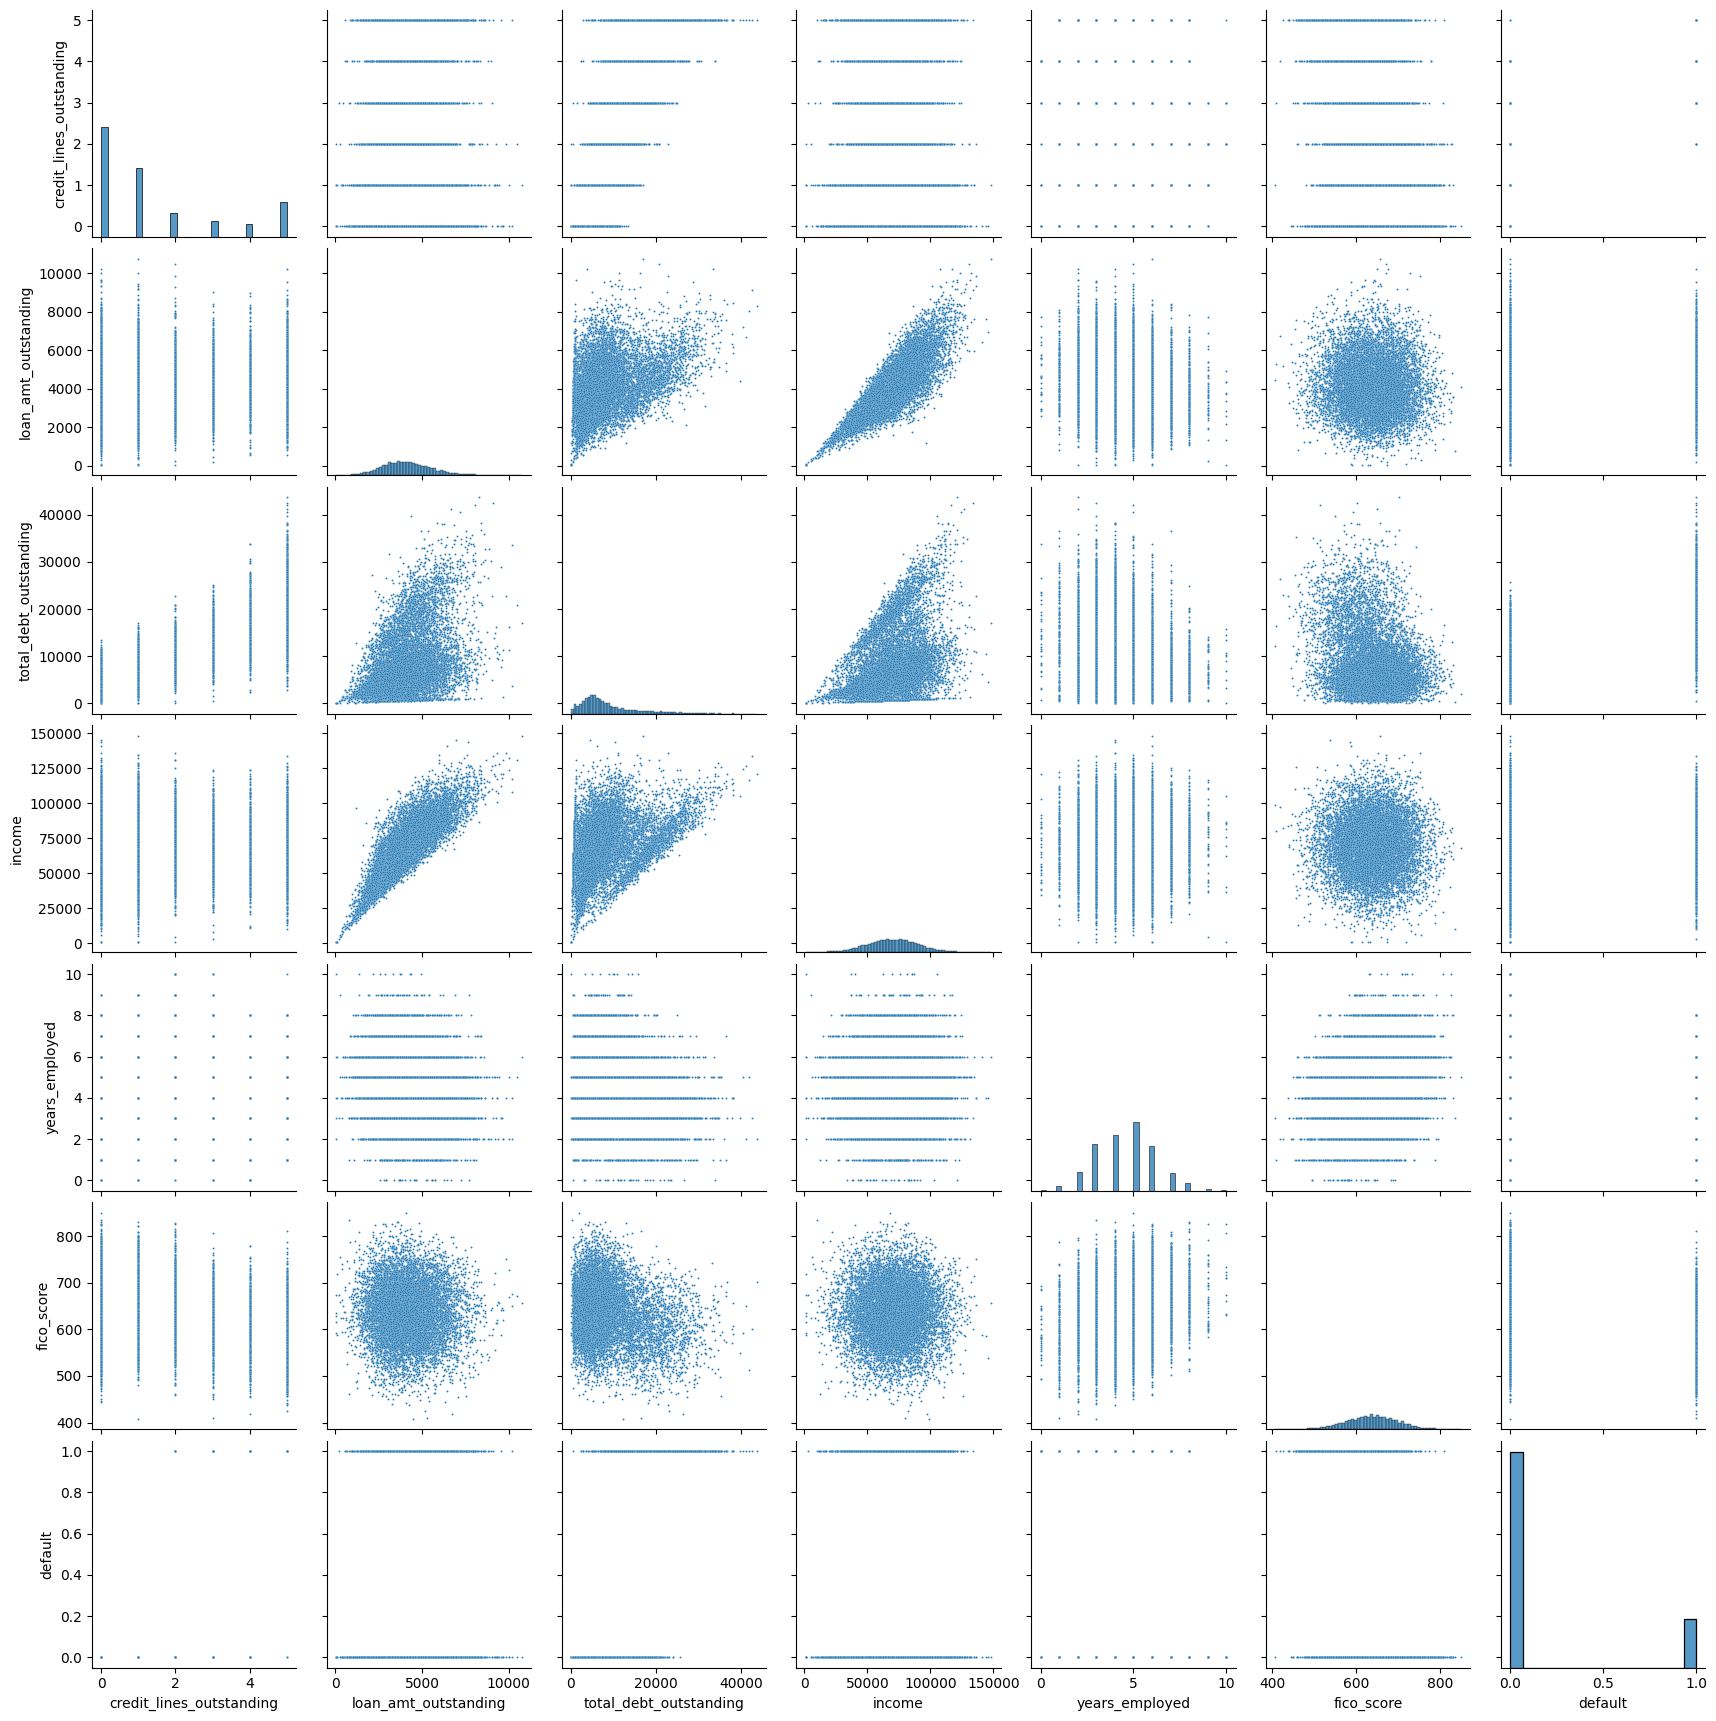

In [ ]:
sns.pairplot(df, plot_kws={'s':2})

Models to try: logistic regression, random forest, svm, neural network. XGBoost were previously attempted but then omitted because of libraries incompatibility.

In [ ]:
class LoanDefaultPredictor:
  def __init__(self, X, y):
    """
    Initialize the loan default prediction pipeline

    Parameters:
    X (numpy array or DataFrame): Feature matrix
    y (numpy array or Series): Target variable
    """
    # Split the data
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,
                                                                            y,
                                                                            test_size=0.2,
                                                                            random_state=12,
                                                                            stratify=y)
    # Scale the features
    self.scaler = StandardScaler()
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    self.X_test_scaled = self.scaler.transform(self.X_test)

    # Initialize models with default parameters
    self.models = {
        'Logistic Regression': LogisticRegression(random_state=12),
        'Random Forest': RandomForestClassifier(random_state=12),
        # 'XGBoost': XGBClassifier(random_state=12),
        'SVM': SVC(probability=True, random_state=12),
        'Neural Network': MLPClassifier(random_state=12)
    }

    # Hyperparameter grids for tuning
    self.param_grids = {
        'Logistic Regression': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            # 'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        },
        'SVM': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        },
        'Neural Network': {
            'hidden_layer_sizes': [(50, ), (100, ), (50, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01]
        },
        # 'XGBoost': {
        #     'n_estimators': [100, 200, 300],
        #     'learning_rate': [0.01, 0.1, 0.3],
        #     'max_depth': [3, 5, 7]
        # }

    }

  def perform_grid_search(self, model_name):
    """
    Perform GridSearchCV for a specific model

    Parameters:
    model_name (str): Name of the model to tune

    Returns:
    Best estimator after hyperparameter tuning
    """

    model = self.models[model_name]
    param_grid = self.param_grids[model_name]

    grid_search = GridSearchCV(model,
                              param_grid,
                              cv=5,
                              scoring='roc_auc',
                              n_jobs=-1)
    grid_search.fit(self.X_train_scaled, self.y_train)

    print(f"\n{model_name} - Best Parameters:")
    print(grid_search.best_params_)
    print(f"Best ROC AUC: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

  def evaluate_model(self, model, model_name):
    """
    Evaluate model performance

    Parameters:
    model (estimator): Trained model
    model_name (str): Name of the model

    Returns:
    Dictionary of performance metrics
    """

    # Predictions
    y_pred = model.predict(self.X_test_scaled)
    y_pred_proba = model.predict_proba(self.X_test_scaled)[:, 1]

    # Metrics
    metrics = {
        'Accuracy' : accuracy_score(self.y_test, y_pred),
        'Precision': precision_score(self.y_test, y_pred),
        'Recall': recall_score(self.y_test, y_pred),
        'F1 Score': f1_score(self.y_test, y_pred),
        'ROC AUC': roc_auc_score(self.y_test, y_pred_proba)
    }

    # Print results
    print(f"\n{model_name} - Performance Metrics:")
    for metric, value in metrics.items():
      print(f"{metric}: {value:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(self.y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return metrics

  def run_pipeline(self):
    """
    Run complete mode evaluation pipeline

    Returns:
    Dictionary of model performances
    """
    model_performances = {}

    for model_name, model in self.models.items():
      print(f"\n--- {model_name} ---")

      # Perform grid search and hyperparameter tuning
      tuned_model = self.perform_grid_search(model_name)

      # Evaluate model
      performance = self.evaluate_model(tuned_model, model_name)
      model_performances[model_name] = performance

    return model_performances


--- Logistic Regression ---

Logistic Regression - Best Parameters:
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC: 1.0000

Logistic Regression - Performance Metrics:
Accuracy: 0.9990
Precision: 0.9946
Recall: 1.0000
F1 Score: 0.9973
ROC AUC: 1.0000


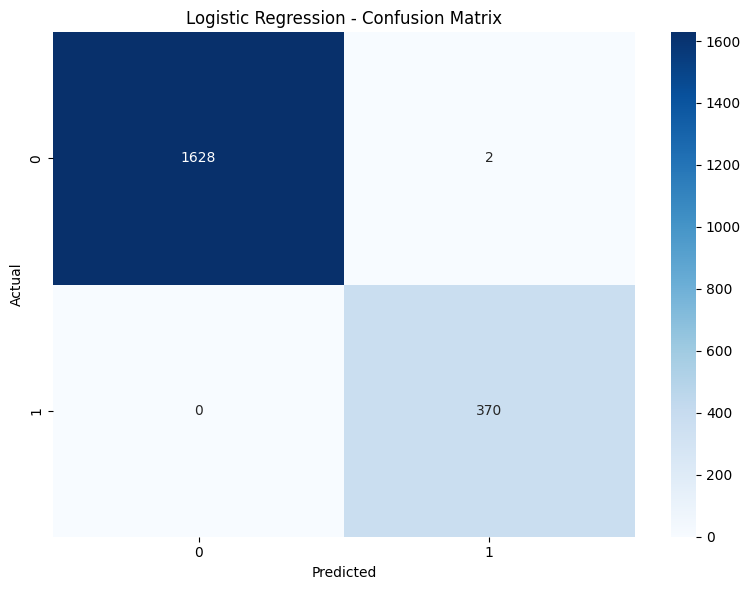


--- Random Forest ---

Random Forest - Best Parameters:
{'max_depth': 7, 'n_estimators': 200}
Best ROC AUC: 0.9998

Random Forest - Performance Metrics:
Accuracy: 0.9935
Precision: 0.9811
Recall: 0.9838
F1 Score: 0.9825
ROC AUC: 0.9998


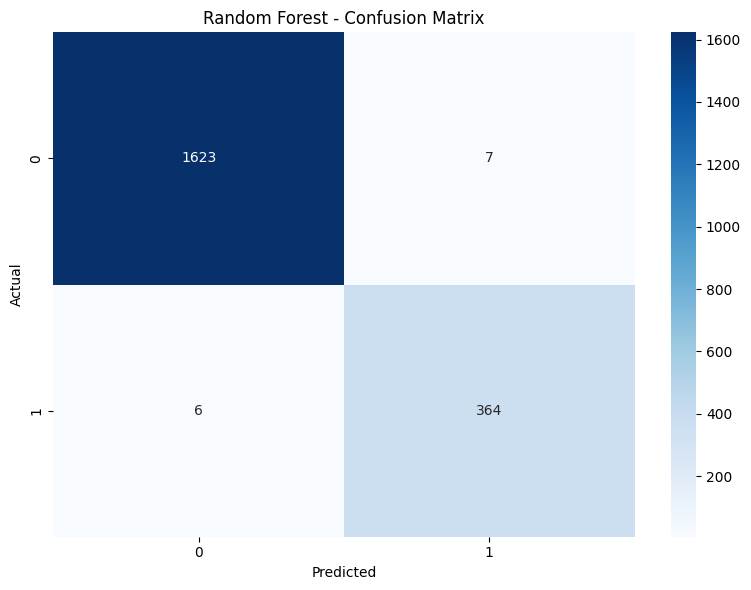


--- SVM ---

SVM - Best Parameters:
{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best ROC AUC: 1.0000

SVM - Performance Metrics:
Accuracy: 0.9990
Precision: 0.9946
Recall: 1.0000
F1 Score: 0.9973
ROC AUC: 1.0000


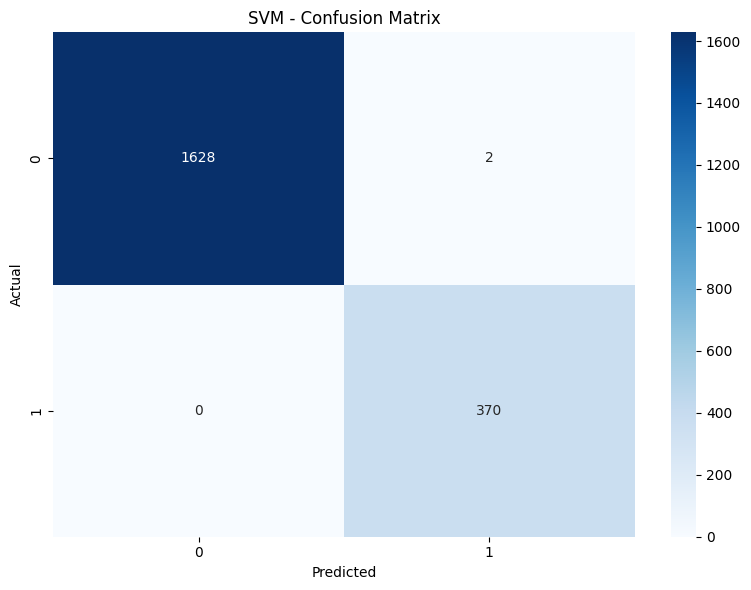


--- Neural Network ---

Neural Network - Best Parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Best ROC AUC: 1.0000

Neural Network - Performance Metrics:
Accuracy: 0.9985
Precision: 0.9946
Recall: 0.9973
F1 Score: 0.9960
ROC AUC: 1.0000


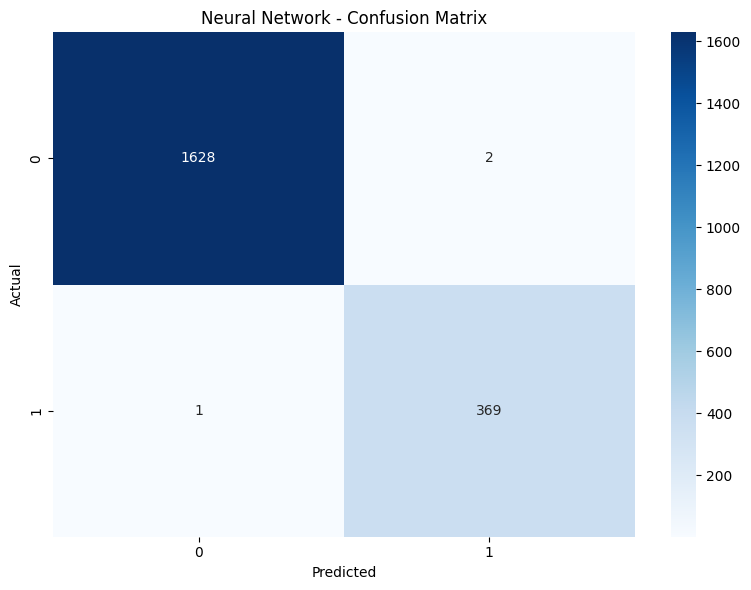

In [ ]:
X = df.drop('default', axis=1)
y = df['default']

predictor = LoanDefaultPredictor(X, y)
results = predictor.run_pipeline()

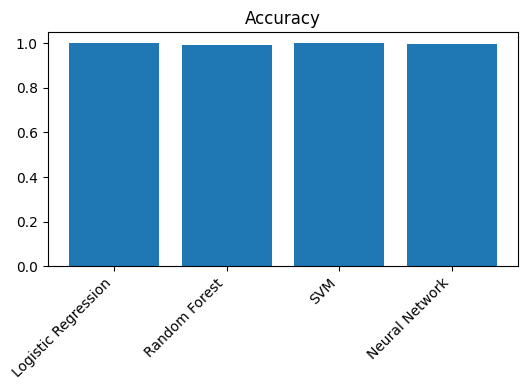

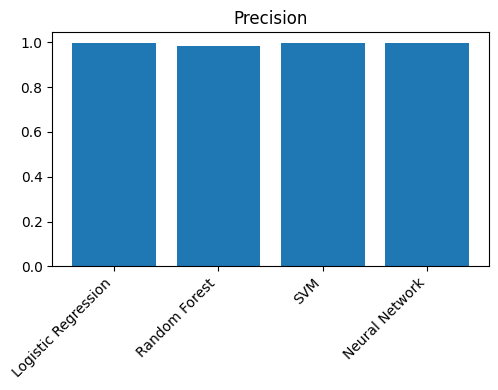

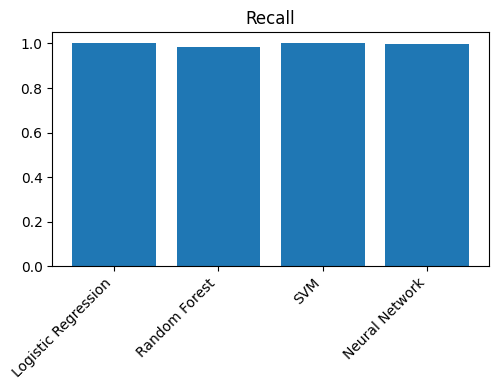

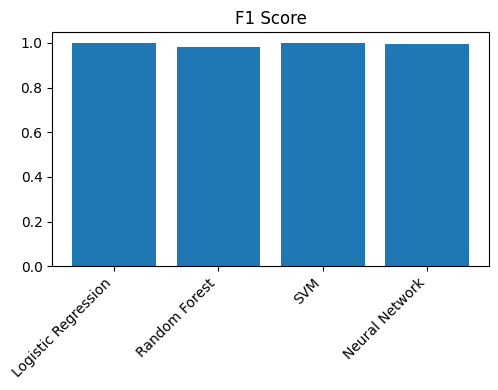

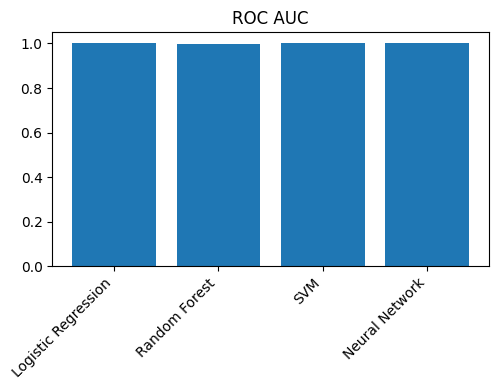

In [ ]:
# Comparative performance visualization

def plot_model_comparison(model_performances):
  metrics = list(list(model_performances.values())[0].keys())


  for i , metric in enumerate(metrics):
    plt.figure(figsize=(25, 4))
    plt.subplot(1, len(metrics), i+1)
    values = [perf[metric] for perf in model_performances.values()]
    plt.bar(model_performances.keys(), values)
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_model_comparison(results)